In [11]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


## Based on http://paedia.info/quickstart/pyneuron.html ##

In [2]:
import numpy as np
import neuron
nrn = neuron.h

In [3]:
def full_morph_pulse_stim_simulation():
    """
    Runs a NEURON simulation and returns an LFPy cell object for a current pulse input.

    :return: cell object where cell.imem gives transmembrane currents, cell.vmem gives membrane potentials.
             See LFPy documentation for more details and examples.
    """
    from hay_model.hay_active_declarations import active_declarations
    import LFPy
    from os.path import join

    conductance_type = 'passive_uniform'

    model_path = join('hay_model')
    neuron.load_mechanisms(join(model_path, 'mod'))
    cell_parameters = {
        'morphology': join(model_path, 'cell1.hoc'),
        'v_init': -65,
        'passive': False,
        'nsegs_method': 'lambda_f',
        'lambda_f': 100,
        'timeres_NEURON': 2**-3, # Should be a power of 2
        'timeres_python': 2**-3,
        'tstartms': 0,
        'tstopms': 200,
        'custom_code': [join(model_path, 'custom_codes.hoc')],
        'custom_fun': [active_declarations],  # will execute this function
        'custom_fun_args': [{'conductance_type': conductance_type}],
    }
    cell = LFPy.Cell(**cell_parameters)
    pointprocess = {
                'idx': 0,
                'record_current': True,
                'pptype': 'IClamp',
                'amp': 0.05,
                'dur': 1e9,
                'delay': 10,
                }
    stimulus = LFPy.StimIntElectrode(cell, **pointprocess)
    cell.simulate(rec_imem=True, rec_vmem=True)

    noise = 0#np.random.normal(0, 0.0002*np.sqrt(np.average(cell.somav**2)), size=cell.somav.shape)
    np.save('exp_t.npy', cell.tvec)
    np.save('exp_v.npy', cell.somav + noise)

    plot(cell.tvec, cell.somav + noise, lw=2, c='gray')
    xlabel('Time [ms]')
    ylabel('Somatic membrane potential [mV]')
    savefig('exercise_4_exp.png')

    # return cell

In [4]:
def return_ball_and_stick_soma():
    """
    Makes a ball-and-stick neuron model.
    :return: soma and dendrite NEURON objects. Both must be returned, or they are lost.
    """
    soma = nrn.Section('soma')
    soma.L = 15  # um; stored as a float number
    soma.diam = 15  # um
    soma.nseg = 1  # stored as an integer

    dend = nrn.Section('dend')
    dend.L = 1000
    dend.diam = 2
    dend.nseg = int(dend.L/10)

    dend.connect(soma, 1, 0)

    for sec in nrn.allsec():
        sec.insert('pas')
        sec.Ra = 100
        sec.cm = 1
        for seg in sec:
            seg.g_pas = 0.00003
            seg.e_pas = -65
    #print "Ball and stick membrane time constant:",  1e-3 * 1/0.0003 * 1
    return soma, dend

In [5]:
def return_lone_soma():
    """
    Makes a neuron model containing a single soma.
    :return: soma NEURON object. This must be returned, or it is lost.
    """

    soma = nrn.Section('soma')
    soma.L = 15  # um; stored as a float number
    soma.diam = 15  # um
    soma.nseg = 1  # stored as an integer

    for sec in nrn.allsec():
        sec.insert('pas')
        sec.Ra = 100
        sec.cm = 1
        for seg in sec:
            seg.g_pas = 0.00003
            seg.e_pas = -65
    #print "Lone soma membrane time constant:",  1e-3 * 1/0.0003 * 1
    return soma

In [6]:
def insert_current_clamp(input_site, dur=1e9):
    """
    Inserts a current clamp in the neuron model
    :param input_site: Where to place the current clamp. Example: soma(0.5), where 0.5 means 'center',
           0 would mean start, and 1 would mean at the end of the segment in question.
           dur: Duration of the current pulse.
    :return: The NEURON object current clamp. This must be returned, otherwise it is lost.
    """
    stim = nrn.IClamp(input_site)
    stim.delay = 10
    stim.amp = 0.005
    stim.dur = dur
    return stim

In [7]:
def run_simulation(record_site):
    """
    Runs the NEURON simulation
    :param record_site: Where to record membrane potential from. Example: soma(0.5), where 0.5 means 'center',
           0 would mean start, and 1 would mean at the end of the segment in question.
    :return: Time and voltage numpy arrays
    """
    rec_t = nrn.Vector()
    rec_t.record(nrn._ref_t)
    # Record Voltage from the record site
    rec_v = nrn.Vector()
    rec_v.record(record_site._ref_v)
    neuron.h.dt = 2**-3
    nrn.finitialize(-65)
    neuron.init()
    neuron.run(200)
    return np.array(rec_t), np.array(rec_v)

In [8]:
def exercise_4_1():

    #full_morph_pulse_stim_simulation()

    exp_t = np.load('exp_t.npy')
    exp_somav = np.load('exp_v.npy')
    v_norm_exp = (exp_somav - exp_somav[0]) / np.max(np.abs(exp_somav - exp_somav[0]))

    soma_eccles = return_lone_soma()
    stim2 = insert_current_clamp(soma_eccles(0.5))
    t, v_eccles = run_simulation(soma_eccles(0.5))
    v_norm_eccles = (v_eccles - v_eccles[0]) / np.max(np.abs(v_eccles - v_eccles[0]))

    del soma_eccles, stim2

    soma_rall, dend_rall = return_ball_and_stick_soma()
    stim1 = insert_current_clamp(soma_rall(0.5))
    t, v_rall = run_simulation(soma_rall(0.5))
    v_norm_rall = (v_rall - v_rall[0]) / np.max(np.abs(v_rall - v_rall[0]))

    # func = lambda tau, args: 1 - np.exp(-t / tau) - args[0]
    # [tau_eccles], cov = leastsq(func, x0=[5], args=[v_norm_eccles])
    # [tau_rall], cov = leastsq(func, x0=[5], args=[v_norm_rall])
    # print tau_eccles, tau_rall

    fig = figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212, xlim=[0, 100], ylim=[-0.1, 1.1])

    ax1.plot(t, exp_somav, 'gray', label='"Experiment"')
    ax2.plot(t, v_norm_exp, 'gray', label='"Experiment"')

    ax1.plot(t, v_eccles, 'b', label='Eccles')
    ax2.plot(t, v_norm_eccles, 'b', label='Eccles')

    ax1.plot(t, v_rall, 'g', label='Rall')
    ax2.plot(t, v_norm_rall, 'g',  label='Rall')

    ax1.set_xlabel("Time [ms]")
    ax2.set_xlabel("Time [ms]")
    ax1.set_ylabel("Voltage [mV]")
    ax2.set_ylabel("Normalized voltage")
    legend(loc=4, frameon=False)

    savefig('exercise_4_1.png')

In [9]:
def exercise_4_2():

    dend_positions = np.linspace(0, 1, 5)
    fig = figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212, xlim=[0, 100], ylim=[-0.1, 1.1])
    soma, dend = return_ball_and_stick_soma()

    nrn.distance(sec=dend)

    for dend_pos in dend_positions:
        stim = insert_current_clamp(dend(dend_pos), dur=5)
        stim_pos = nrn.distance(dend_pos, sec=dend)
        t, v = run_simulation(soma(0.5))
        v_norm = (v - v[0]) / np.max(np.abs(v - v[0]))
        ax1.plot(t, v, label='%d' % stim_pos)
        ax2.plot(t, v_norm, label='%d' % stim_pos)

    ax1.set_xlabel("Time [ms]")
    ax2.set_xlabel("Time [ms]")
    ax1.set_ylabel("Voltage [mV]")
    ax2.set_ylabel("Normalized voltage")
    legend(loc=4, frameon=False)

    savefig('exercise_4_2.png')

## main simulation: ##

<IPython.core.display.Javascript object>


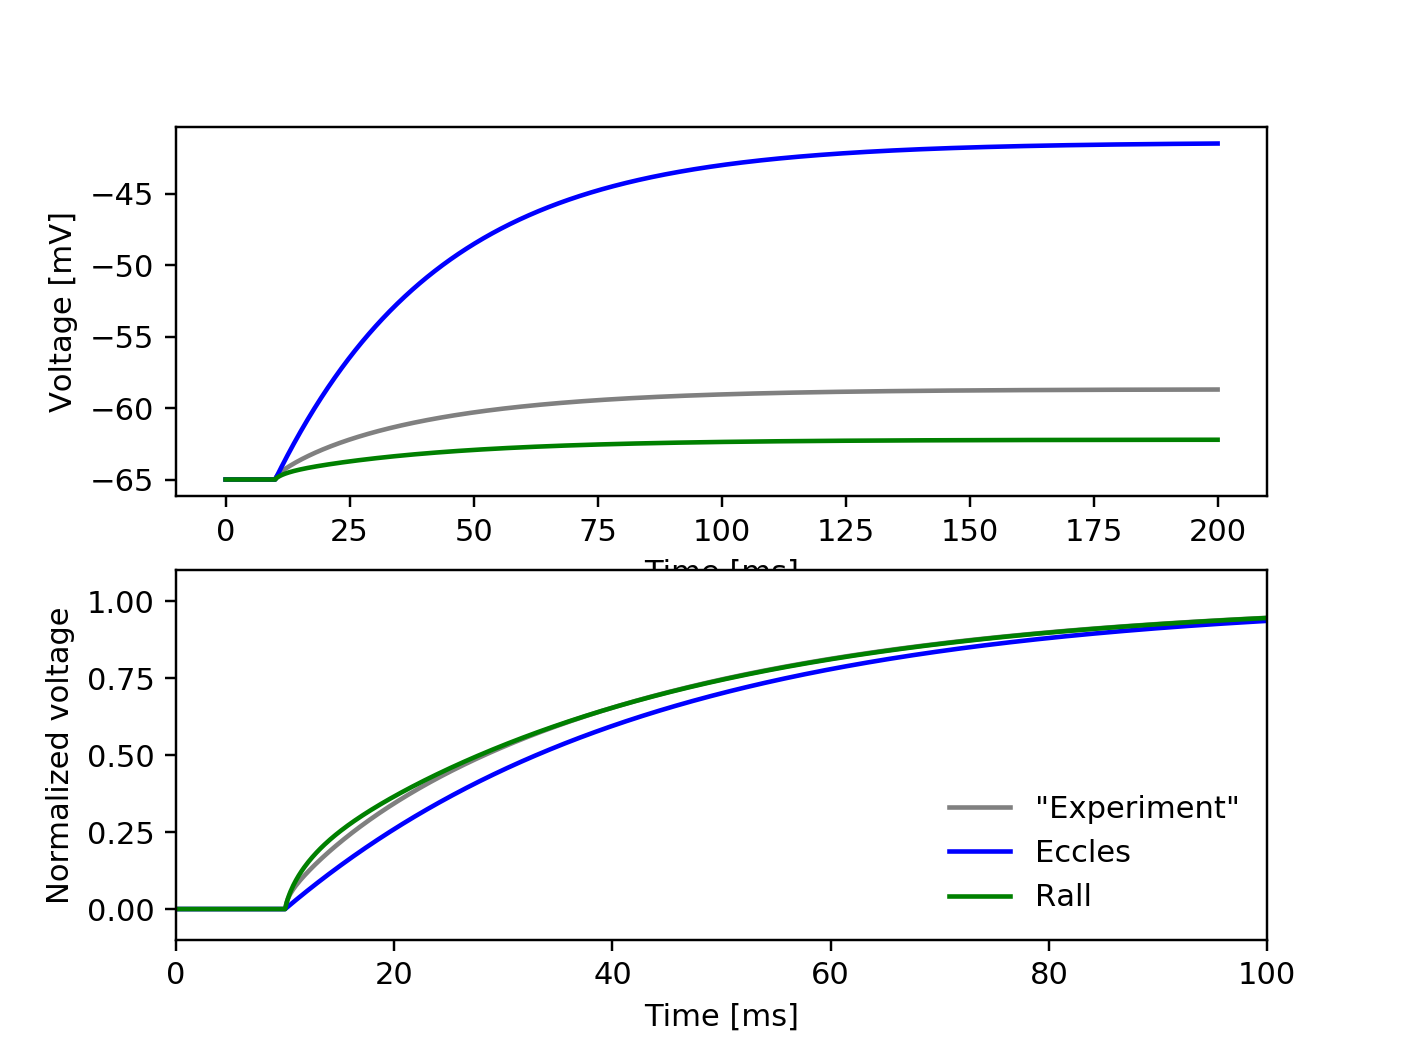

In [12]:
exercise_4_1()

<IPython.core.display.Javascript object>


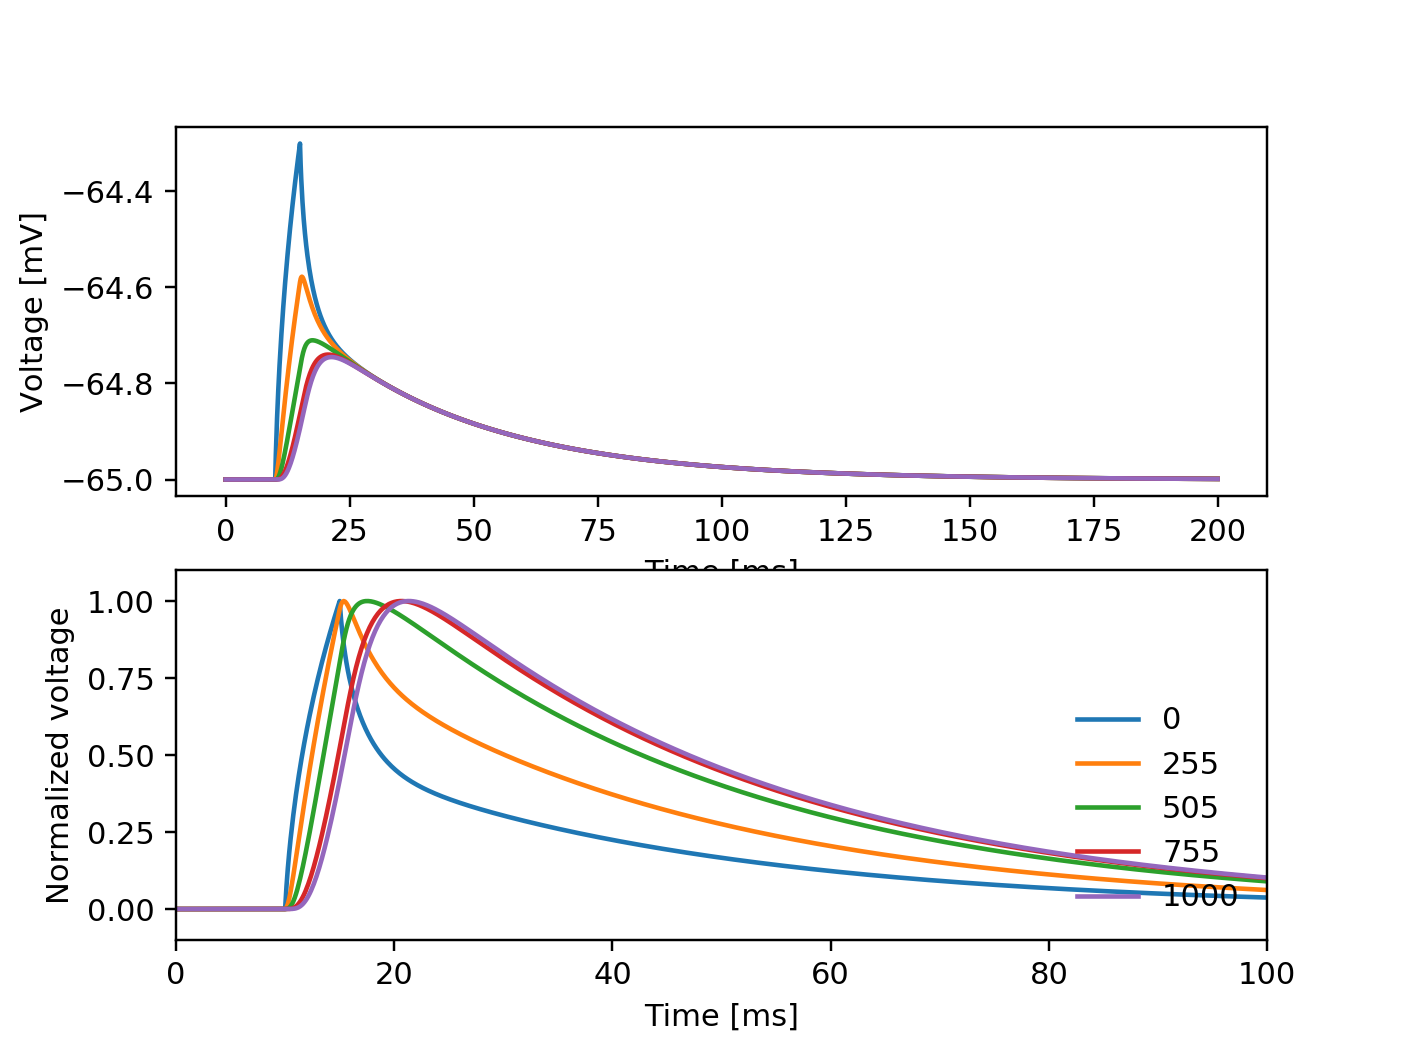

In [13]:
exercise_4_2()